### Notebook para la prueba del error de los ángulos de los brazos


In [1]:
# imports
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import math
import os
import pandas as pd
import pickle as pk
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

# import de utilities de detectron
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

#### Carga de las imágenes de prueba

In [2]:
frames={}
brazosAbajo = cv2.imread("brazosAbajo.jpeg")
frames["brazosAbajo"]=brazosAbajo

brazosArriba = cv2.imread("brazosArriba.jpeg")
frames["brazosArriba"]=brazosArriba

casiEstirados1 = cv2.imread("casiEstirados1.jpeg")
frames["casiEstirados1"]=casiEstirados1

casiEstirados2 = cv2.imread("casiEstirados2.jpeg")
frames["casiEstirados2"]=casiEstirados2

derAbajoizqArriba = cv2.imread("derAbajoizqArriba.jpeg")
frames["derAbajoizqArriba"]=derAbajoizqArriba

derArribaizqAbajo = cv2.imread("derArribaizqAbajo.jpeg")
frames["derArribaizqAbajo"]=derArribaizqAbajo

estirados = cv2.imread("estirados.jpeg")
frames["estirados"]=estirados

estiradosArriba = cv2.imread("estiradosArriba.jpeg")
frames["estiradosArriba"]=estiradosArriba

estiradosAbajo = cv2.imread("estiradosAbajo.jpeg")
frames["estiradosAbajo"]=estiradosAbajo

errorEncogidos1 = cv2.imread("errorEncogidos1.jpeg")
frames["errorEncogidos1"]=errorEncogidos1

errorEncogidos2 = cv2.imread("errorEncogidos2.jpeg")
frames["errorEncogidos2"]=errorEncogidos2

#### Carga del modelo

In [3]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.99  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

#### Obtención de las posiciones

In [4]:
outPred={}
for i in frames:
    outPred[i] = predictor(frames[i])

#### Imágenes con posición

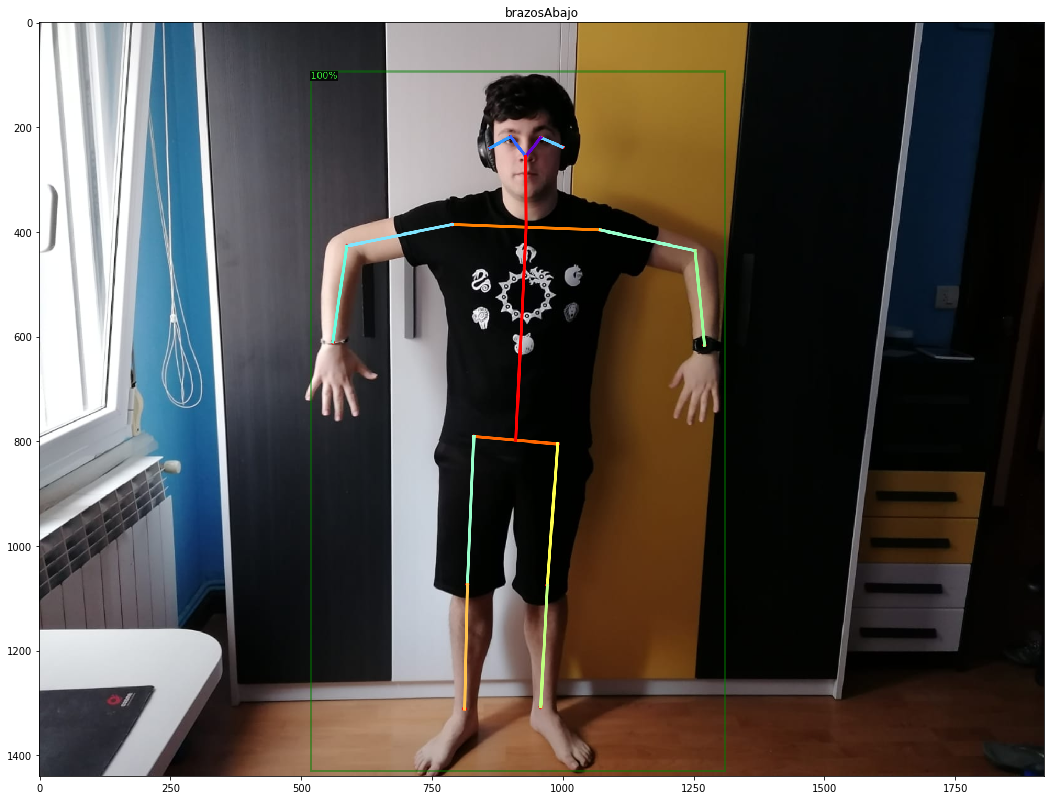

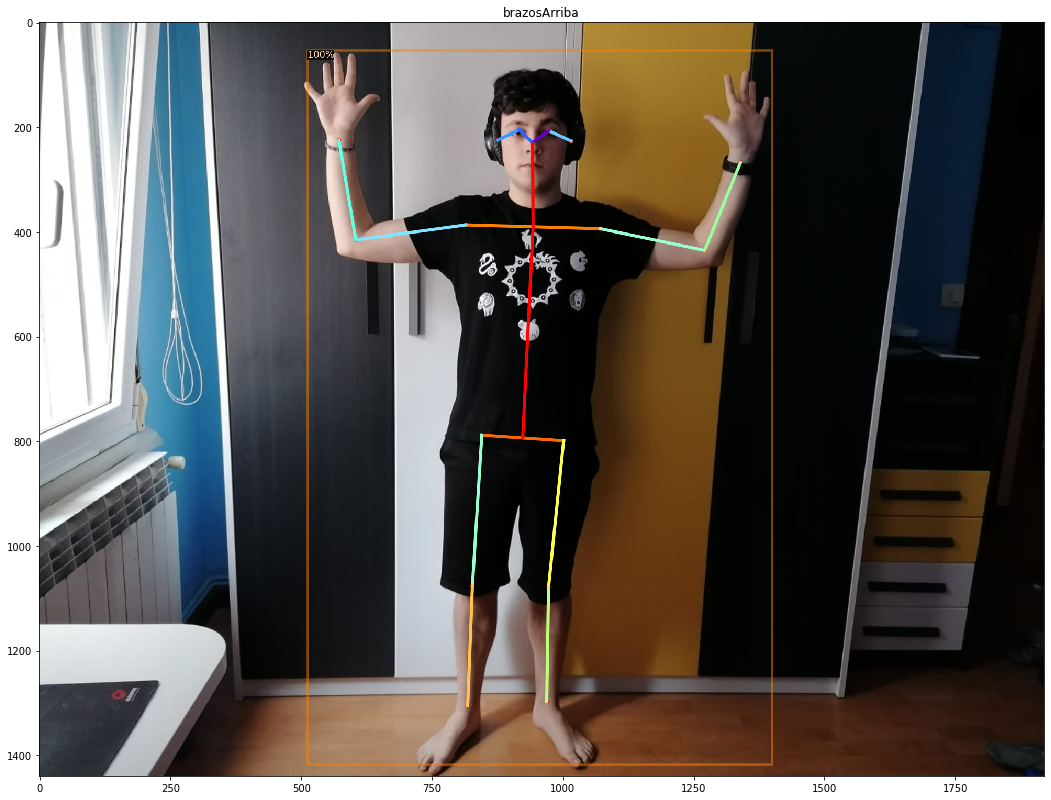

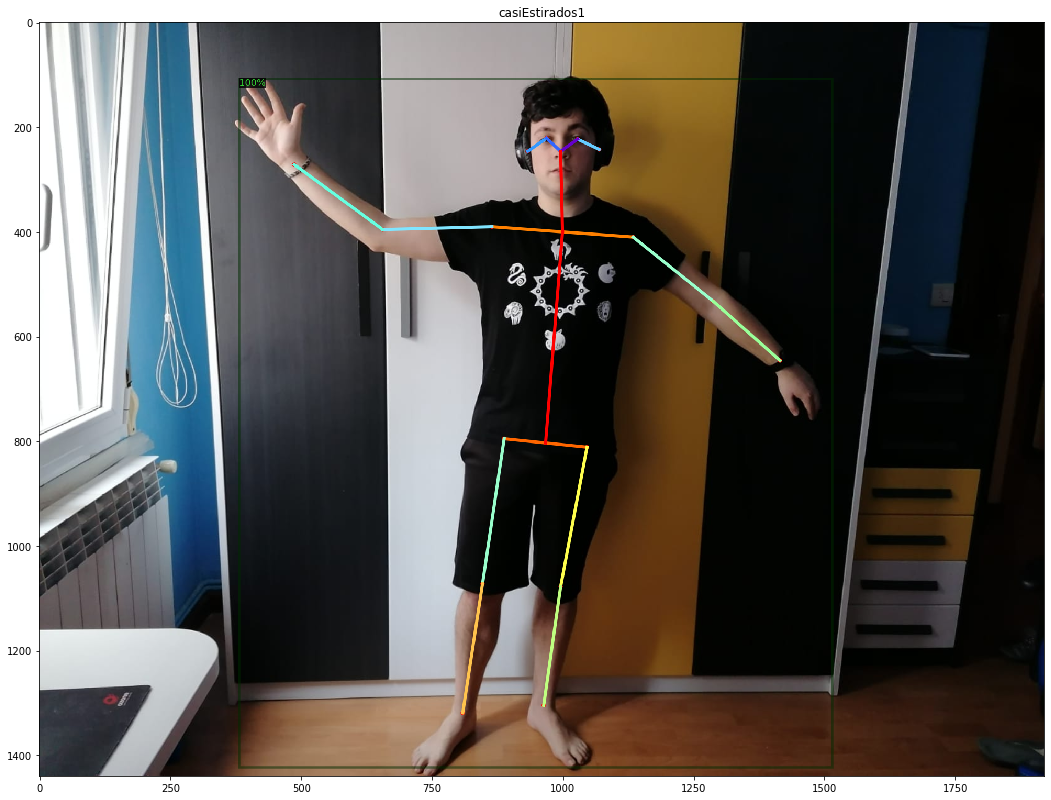

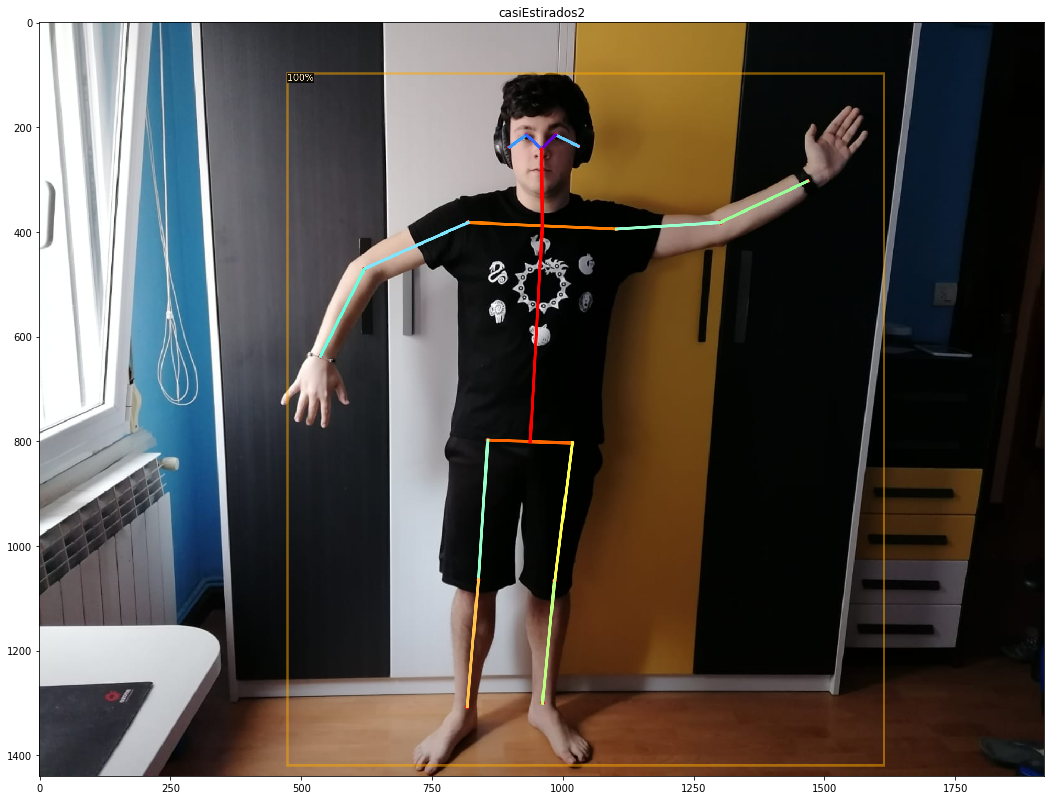

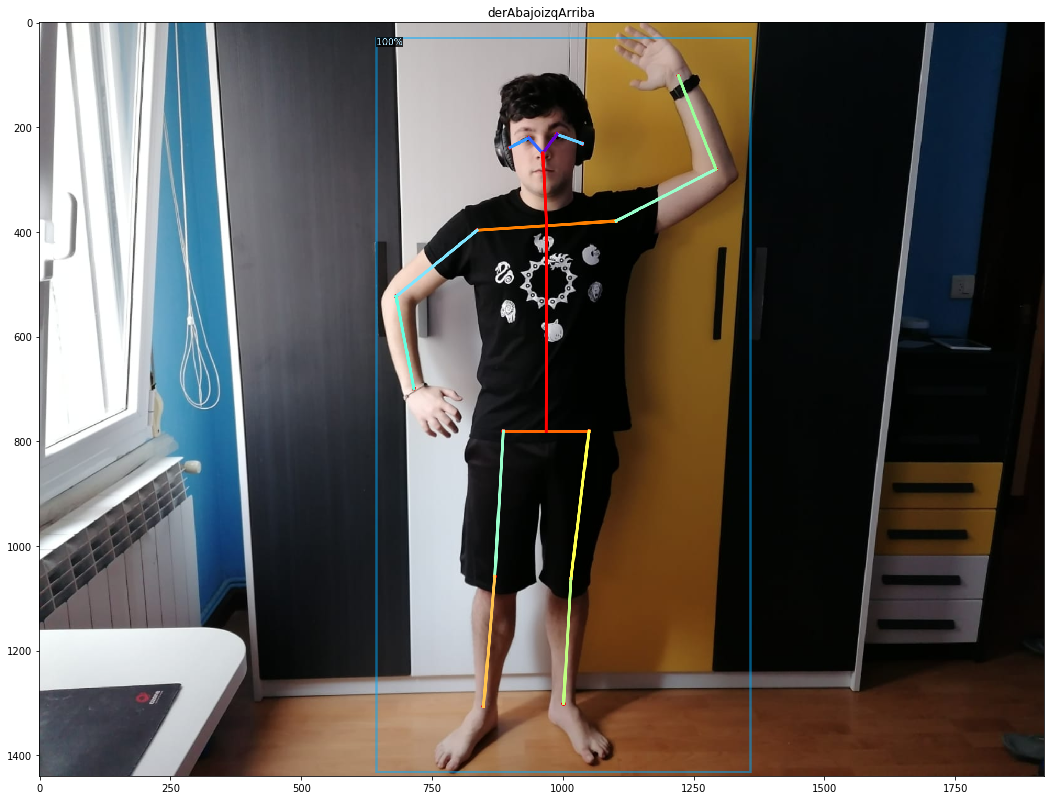

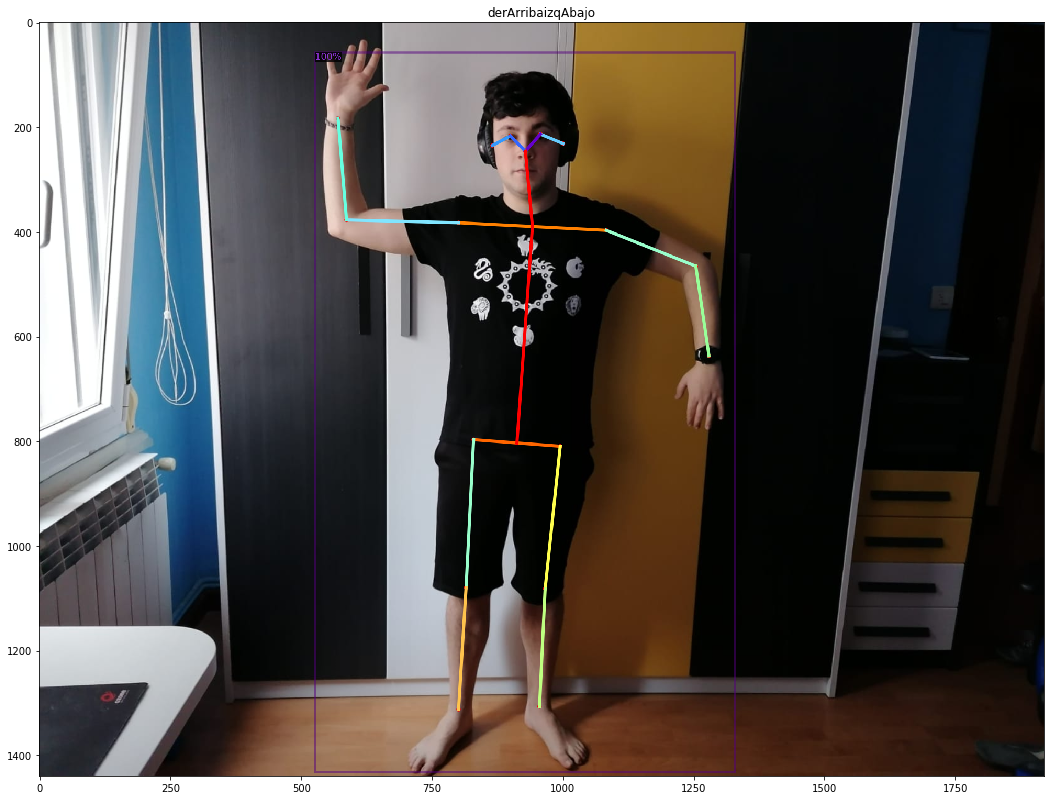

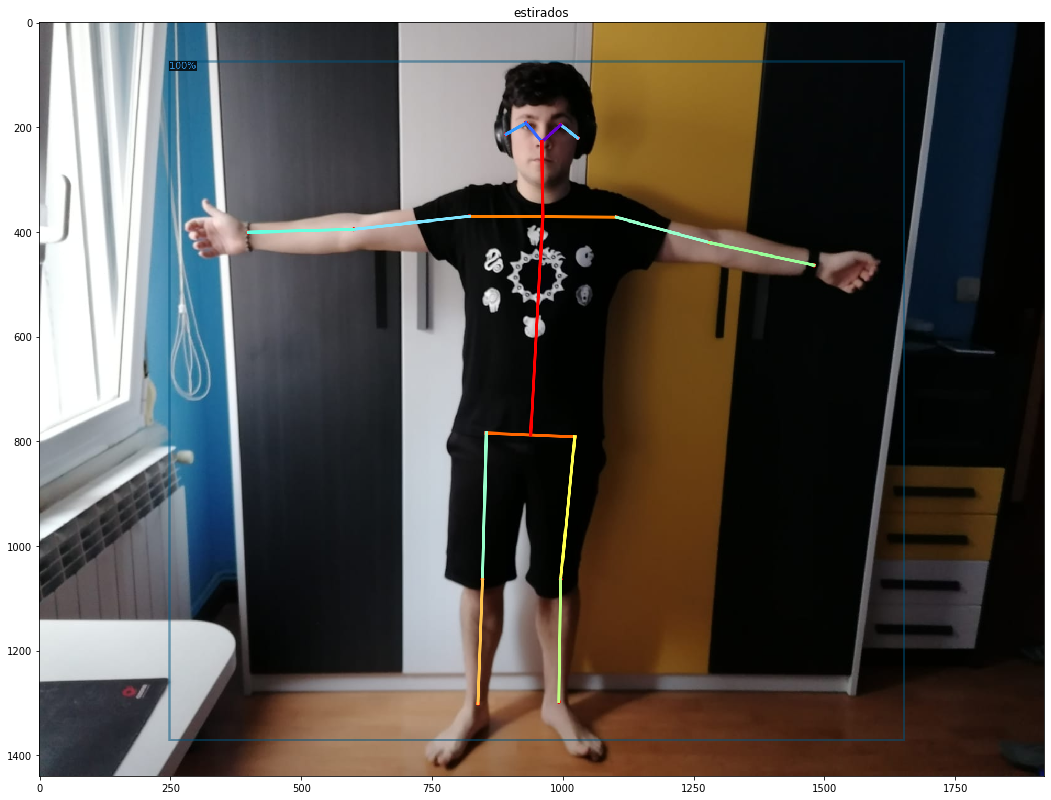

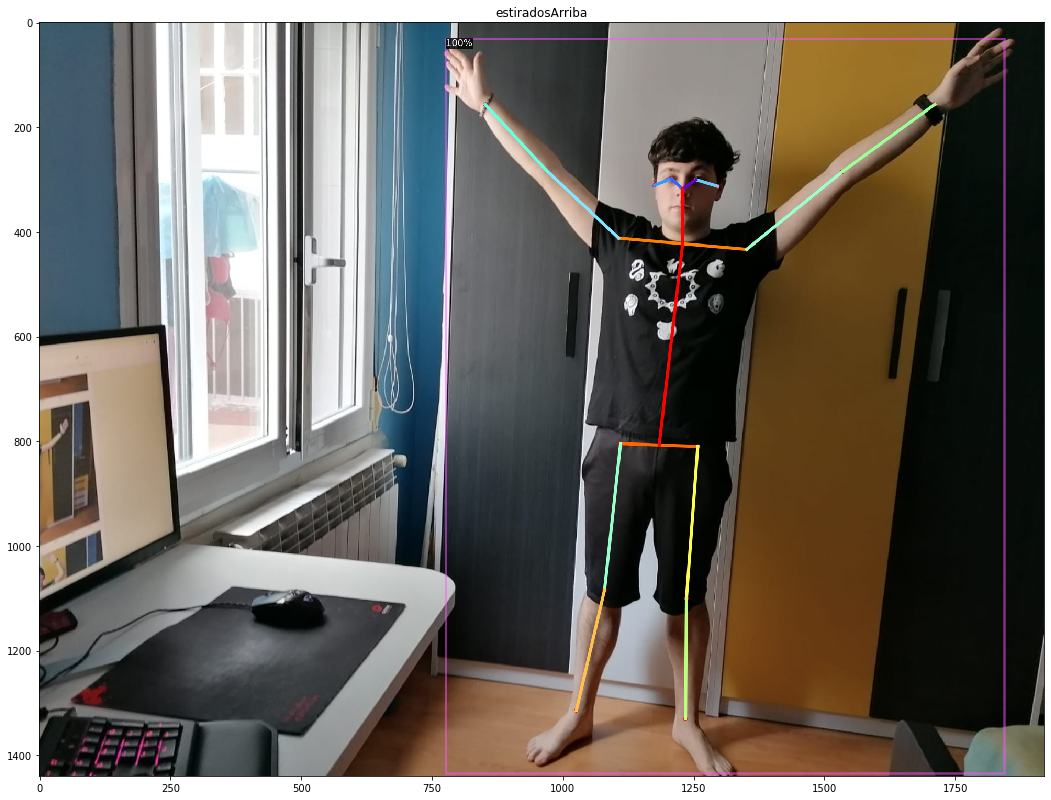

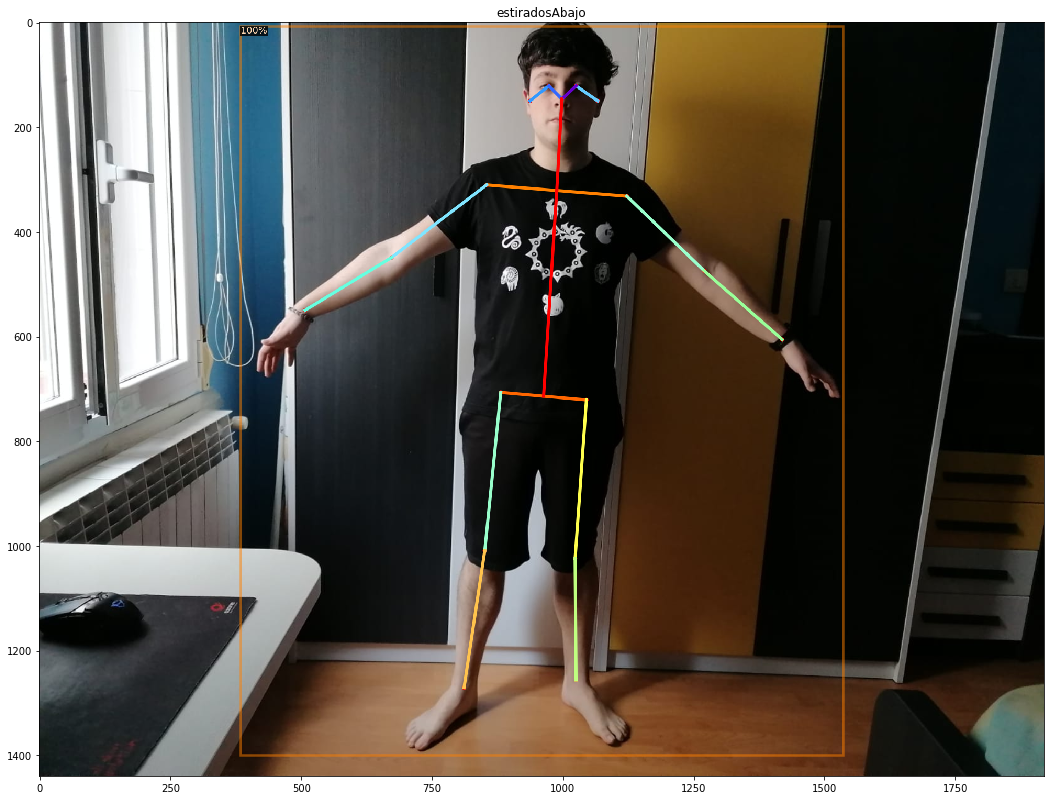

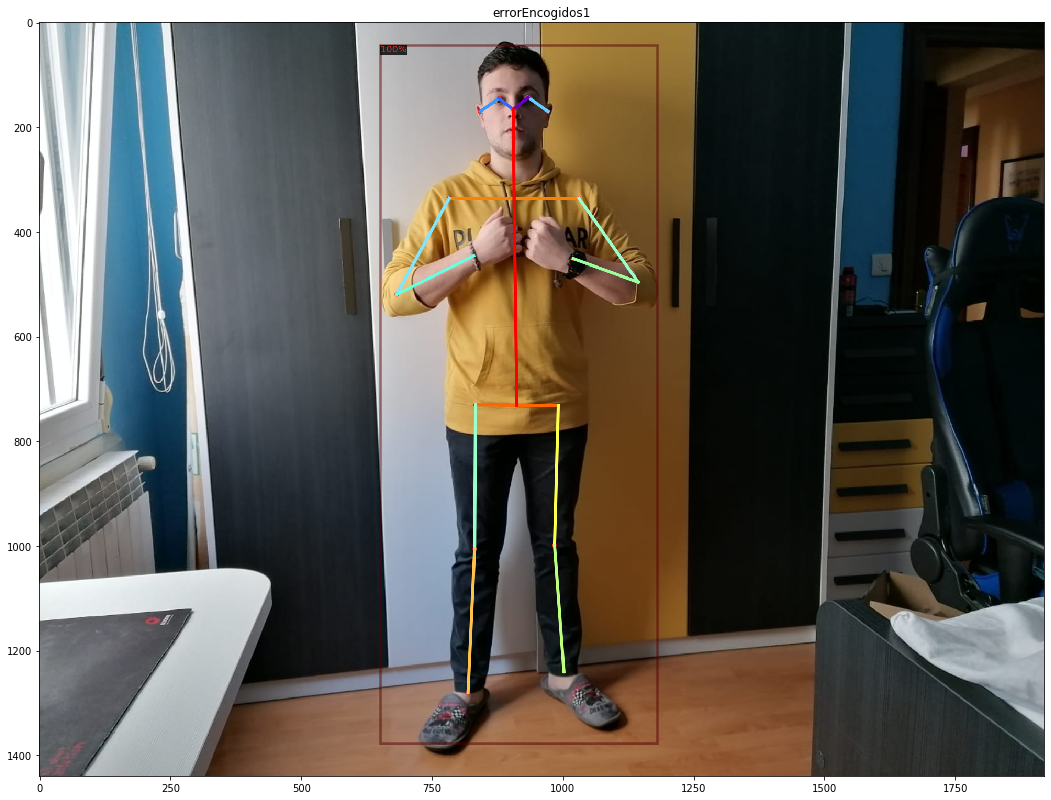

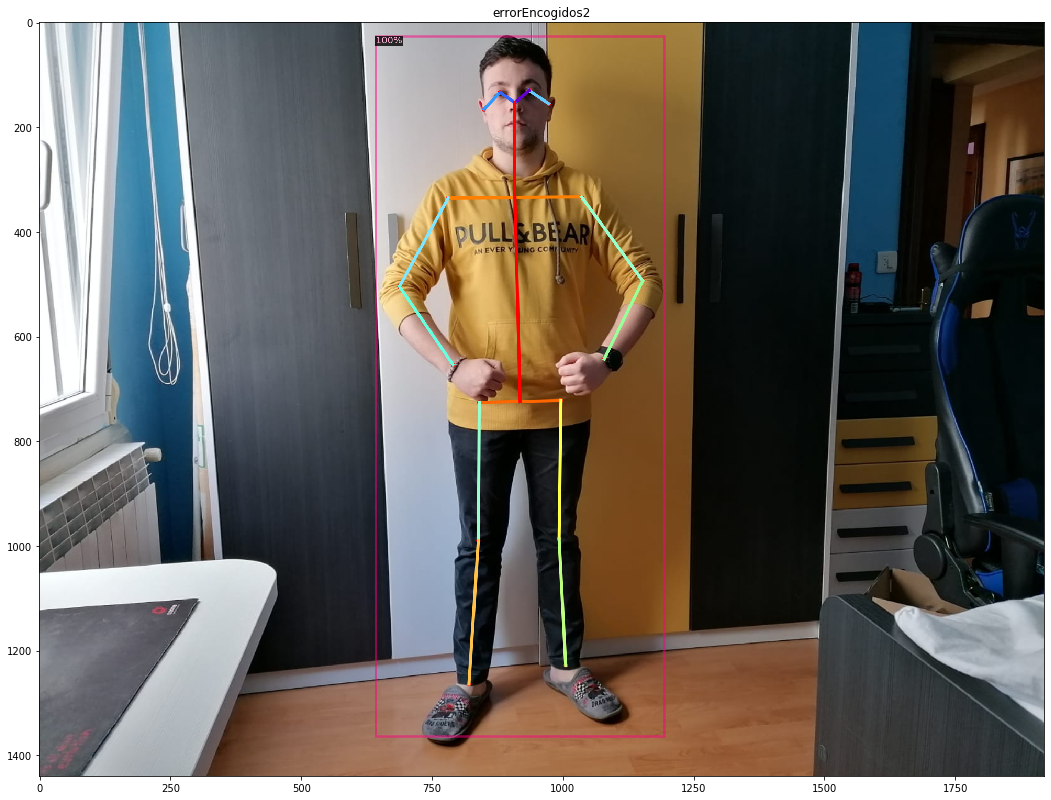

In [5]:
for i in outPred:
    v = Visualizer(frames[i][:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    v2 = v.draw_instance_predictions(outPred[i]["instances"].to("cpu"))
    imVisualizer = cv2.cvtColor(v2.get_image()[:, :, ::-1],cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(18, 16))
    plt.imshow(imVisualizer)
    plt.title(i)
    plt.show()

#### Clase de posición y algoritmos de comparación de posiciones

In [6]:
class Posicion():
    
    def __init__(self,x,y):
        self.nariz = [x[0],y[0]]
        self.ojoI = [x[1],y[1]]
        self.ojoD = [x[2],y[2]]
        self.orejaI=[x[3],y[3]]
        self.orejaD=[x[4],y[4]]
        self.hombroI=[x[5],y[5]]
        self.hombroD=[x[6],y[6]]
        self.cuello = self.calcularPuntoMedio(self.hombroI,self.hombroD)
        self.angCuelloSupI = self.calcularAngulo(self.hombroI,self.cuello,self.nariz)
        self.angCuelloSupD = self.calcularAngulo(self.hombroD,self.cuello,self.nariz)
        self.codoI = [x[7],y[7]]
        self.codoD = [x[8],y[8]]
        self.manoI=[x[9],y[9]]
        self.manoD = [x[10],y[10]]
        self.angCodoI = self.calcularAngulo(self.hombroI,self.codoI,self.manoI)
        self.angCodoD = self.calcularAngulo(self.hombroD,self.codoD,self.manoD)
        self.angHombroI = self.calcularAngulo(self.cuello,self.hombroI,self.codoI)
        self.angHombroD = self.calcularAngulo(self.cuello,self.hombroD,self.codoD)
        self.caderaI = [x[11],y[11]]
        self.caderaD = [x[12],y[12]]
        self.cadera = self.calcularPuntoMedio(self.caderaI,self.caderaD)
        self.angCuelloInfI =self.calcularAngulo(self.hombroI,self.cuello,self.cadera)
        self.angCuelloInfD =self.calcularAngulo(self.hombroD,self.cuello,self.cadera)
        self.rodillaI = [x[13],y[13]]
        self.rodillaD = [x[14],y[14]]
        self.angCaderaI = self.calcularAngulo(self.cadera,self.caderaI,self.rodillaI)
        self.angCaderaD = self.calcularAngulo(self.cadera,self.caderaD,self.rodillaD)
        self.angCaderaTorsoI = self.calcularAngulo(self.cuello,self.cadera,self.caderaI)
        self.angCaderaTorsoD = self.calcularAngulo(self.cuello,self.cadera,self.caderaD)
        self.tobilloI = [x[15],y[15]]
        self.tobilloD = [x[16],y[16]]
        self.angRodillaI = self.calcularAngulo(self.caderaI,self.rodillaI,self.tobilloI)
        self.angRodillaD = self.calcularAngulo(self.caderaD,self.rodillaD,self.tobilloD)
        self.distAntebrazoI = self.calcularDistancia(self.manoI,self.codoI)
        self.distAntebrazoD = self.calcularDistancia(self.manoD,self.codoD)
        self.distBrazoI = self.calcularDistancia(self.codoI,self.hombroI)
        self.distBrazoD = self.calcularDistancia(self.codoD,self.hombroD)
        self.distCuello = self.calcularDistancia(self.nariz,self.cuello)
        self.distTronco = self.calcularDistancia(self.cuello,self.cadera)
        self.distMusloI = self.calcularDistancia(self.caderaI,self.rodillaI)
        self.distMusloD = self.calcularDistancia(self.caderaD,self.rodillaD)
        self.distPiernaI = self.calcularDistancia(self.rodillaI,self.tobilloI)
        self.distPiernaD = self.calcularDistancia(self.rodillaD,self.tobilloD)
        self.distHombros = self.calcularDistancia(self.hombroI,self.hombroD)
        self.distCadera = self.calcularDistancia(self.caderaI,self.caderaD)
        
    def calcularPuntoMedio(self,p1,p2):
        return [(p1[0]+p2[0])/2,(p1[1]+p2[1])/2]
    
    def calcularAngulo(self,p1,p2,p3):
        v1 = self.calcularVector(p1,p2)
        v2 = self.calcularVector(p3,p2)
        uv1 = v1 / np.linalg.norm(v1)
        uv2 = v2 / np.linalg.norm(v2)
        dp = np.dot(uv1, uv2)
        return math.degrees(np.arccos(dp))
    
    def calcularVector(self,p1,p2):
        return [p2[0]-p1[0],p2[1]-p1[1]]
    
    def calcularDistancia(self,p1,p2):
        return ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)**0.5
    
    def devuelveAngulos(self):
        return [self.angCuelloSupI,self.angCuelloSupD,self.angCodoI,self.angCodoD,self.angHombroI,self.angHombroD,
               self.angCuelloInfI,self.angCuelloInfD,self.angCaderaI,self.angCaderaD,self.angRodillaI,self.angRodillaD,
               self.angCaderaTorsoI,self.angCaderaTorsoD]

In [7]:
#Penalización si los brazos están en sentidos contrarios
#Diferencia de grados para considerar a un brazo estirado, por lo que no se tiene que penalizar
def compararBrazos(pos1,pos2,penalizacionCodo = 180,penalizacionHombro=90, diferenciaEstirado=10):
    partes=["D","I"]
    res=0.0
    pos=[pos1,pos2]
    
    for j in partes:
        res+= abs(eval("pos1.angCodo"+j)-eval("pos2.angCodo"+j))
        res+= abs(eval("pos1.angHombro"+j)-eval("pos2.angHombro"+j))
        auxCodo = []
        auxHombro = []
        for i in pos:
            
            #Si el brazo está estirado
            if  180-diferenciaEstirado <= eval("i.angCodo"+j) <= 180+diferenciaEstirado:
                auxCodo.append(0)
            #Si no está estirado
            else:
                if eval("i.mano"+j+"[1]") > eval("i.codo"+j+"[1]"):
                    auxCodo.append(1)
                else: 
                    auxCodo.append(2)
            
            # Si el angulo del hombro es casi 180 entonces 0
            if  180-diferenciaEstirado <= eval("i.angHombro"+j) <= 180+diferenciaEstirado:
                auxHombro.append(0)
            #Sino comparar si está hacia arriba o hacia abajo
            else:
                if eval("i.codo"+j+"[1]") > eval("i.hombro"+j+"[1]"):
                    auxHombro.append(1)
                else:
                    auxHombro.append(2)
                    
        if (auxCodo[0] == 1 and  auxCodo[1]==2) or (auxCodo[0] == 2 and  auxCodo[1]==1):
            res+=penalizacionCodo
            print("Penalizado brazo " + j)
        if (auxHombro[0] == 1 and  auxHombro[1]==2) or (auxHombro[0] == 2 and  auxHombro[1]==1):
            res+=penalizacionHombro
            print("Penalizado hombro " + j)
    return res

In [8]:
#Penalización si los brazos están en sentidos contrarios
#Diferencia para designar si una brazo está al mismo nivel (0), está arriba (1) o abajo del codo (2)
def compararBrazos2(pos1,pos2,penalizacion = 100,diferenciaPena = 5):
    res=0.0
    
    res+= abs(pos1.angCodoD-pos2.angCodoD)
    bD1 = 0
    
    #Si la diferencia de altura es superior a la establecida se comprueba si está por encima o por debajo
    if abs(pos1.manoD[1]*100/pos1.codoD[1]-100)>diferenciaPena:
        if pos1.manoD[1] > pos1.codoD[1]:
            bD1 = 1
        else: 
            bD1 = 2
    bD2 = 0
    if abs(pos2.manoD[1]*100/pos2.codoD[1]-100)>diferenciaPena:
        if pos2.manoD[1] > pos2.codoD[1]:
            bD2 = 1
        else: 
            bD2 = 2
    #Penalizamos
    if (bD1 == 1 and  bD2==2) or (bD1 == 2 and  bD2==1):
        res+=penalizacion
        print("Penalizado brazo derecho")
    
    res+= abs(pos1.angCodoI-pos2.angCodoI)
    
    bI1 = 0
    if abs(pos1.manoI[1]*100/pos1.codoI[1]-100)>diferenciaPena:
        if pos1.manoI[1] > pos1.codoI[1]:
            bI1 = 1
        else: 
            bI1 = 2
    bI2 = 0
    if abs(pos2.manoI[1]*100/pos2.codoI[1]-100)>diferenciaPena:
        if pos2.manoI[1] > pos2.codoI[1]:
            bI2 = 1
        else: 
            bI2 = 2
    #Penalizamos
    if (bI1 == 1 and  bI2==2) or (bI1 == 2 and  bI2==1):
        res+=penalizacion
        print("Penalizado brazo izquierdo")
    return res

In [9]:
def compararPiernas(pos1,pos2):
    partes = ["D","I"]
    zonas = ["angRodilla","angCadera"]
    res = 0.0
    for i in partes:
        for j in zonas:
            res+=abs(eval("pos1."+j+i)-eval("pos2."+j+i))
    return res

In [10]:
def compararTorso(pos1,pos2):
    partes=["D","I"]
    zonas=["angCaderaTorso","angCuelloSup"]
    res = 0.0
    for i in partes:
        for j in zonas:
            res+=abs(eval("pos1."+j+i)-eval("pos2."+j+i))
    return res

In [11]:
def compararPosiciones(pos1,pos2,penalizacionCodo = 180,penalizacionHombro=90,diferenciaEstirado = 10,pesoBrazos=1,pesoPiernas=1,pesoTorso=1):
    return pesoBrazos*compararBrazos(pos1,pos2,penalizacion,diferenciaEstirado)+pesoPiernas*compararPiernas(pos1,pos2)+pesoTorso*compararTorso(pos1,pos2)

#### De cada output coger puntos y obtener posición

In [12]:
pkPx = {}
pkPy={}
for i in outPred:
    pkP = outPred[i].get("instances").pred_keypoints
    pkPx[i] = pkP[0][:,0].cpu().numpy()
    pkPy[i] = pkP[0][:,1].cpu().numpy()

pos={}
for i in pkPx:
    pos[i]=Posicion(pkPx[i],pkPy[i])

#### Pruebas de comparación

In [13]:
compararBrazos(pos["casiEstirados1"],pos["casiEstirados2"])

Penalizado brazo D


249.34543091228784

In [14]:
compararBrazos2(pos["estirados"],pos["casiEstirados2"])

Penalizado brazo izquierdo


152.84916243886394

In [15]:
pos["estirados"].angCodoI

176.94558539326164

In [16]:
compararBrazos(pos["brazosArriba"],pos["brazosAbajo"])

Penalizado brazo D
Penalizado brazo I


390.0715489017564

In [17]:
compararBrazos(pos["brazosArriba"],pos["derAbajoizqArriba"])

Penalizado brazo D
Penalizado hombro I


340.75370190683634

#### Comparación de todas imágenes

In [18]:
for i in pos:
    for j in pos:
        if i != j:
            print(i + " vs " + j)
            print(compararBrazos(pos[i],pos[j]))
            print()

brazosAbajo vs brazosArriba
Penalizado brazo D
Penalizado brazo I
390.0715489017564

brazosAbajo vs casiEstirados1
Penalizado brazo D
313.83187797646406

brazosAbajo vs casiEstirados2
Penalizado brazo I
277.8465223357334

brazosAbajo vs derAbajoizqArriba
Penalizado brazo I
Penalizado hombro I
325.7512798151271

brazosAbajo vs derArribaizqAbajo
Penalizado brazo D
227.06521846437295

brazosAbajo vs estirados
145.73610824249909

brazosAbajo vs estiradosArriba
Penalizado hombro D
Penalizado hombro I
373.1891438823777

brazosAbajo vs estiradosAbajo
190.83326335789084

brazosAbajo vs errorEncogidos1
Penalizado brazo D
Penalizado brazo I
600.6437664790233

brazosAbajo vs errorEncogidos2
107.46933145054105

brazosArriba vs brazosAbajo
Penalizado brazo D
Penalizado brazo I
390.0715489017564

brazosArriba vs casiEstirados1
155.08379117753083

brazosArriba vs casiEstirados2
Penalizado brazo D
307.9180712374898

brazosArriba vs derAbajoizqArriba
Penalizado brazo D
Penalizado hombro I
340.753701906

In [19]:
pos["derAbajoizqArriba"].angHombroD

144.70019314601177

In [20]:
compararBrazos(pos["estiradosAbajo"],pos["estiradosArriba"])

Penalizado hombro D
Penalizado hombro I


191.11308545880908

In [21]:
pos["estiradosAbajo"].angHombroD

138.049839607573

In [22]:
pos["estiradosArriba"].angHombroD

141.9833186465244

In [23]:
#Posiciones 2
class Posicion2():
    
    def __init__(self,x,y):
        self.nariz = [x[0],y[0]]
        self.ojoI = [x[1],y[1]]
        self.ojoD = [x[2],y[2]]
        self.orejaI=[x[3],y[3]]
        self.orejaD=[x[4],y[4]]
        self.hombroI=[x[5],y[5]]
        self.hombroD=[x[6],y[6]]
        self.cuello = self.calcularPuntoMedio(self.hombroI,self.hombroD)
        self.angCuelloSupI = self.calcularAngulo(self.hombroI,self.cuello,self.nariz)
        self.angCuelloSupD = self.calcularAngulo(self.hombroD,self.cuello,self.nariz)
        self.codoI = [x[7],y[7]]
        self.codoD = [x[8],y[8]]
        self.manoI=[x[9],y[9]]
        self.manoD = [x[10],y[10]]
        self.angCodoI = self.calcularAngulo(self.hombroI,self.codoI,self.manoI)
        self.angCodoD = self.calcularAngulo(self.hombroD,self.codoD,self.manoD)
        self.angHombroI = self.calcularAngulo(self.cuello,self.hombroI,self.codoI)
        self.angHombroD = self.calcularAngulo(self.cuello,self.hombroD,self.codoD)
        self.caderaI = [x[11],y[11]]
        self.caderaD = [x[12],y[12]]
        self.cadera = self.calcularPuntoMedio(self.caderaI,self.caderaD)
        self.angCuelloInfI =self.calcularAngulo(self.hombroI,self.cuello,self.cadera)
        self.angCuelloInfD =self.calcularAngulo(self.hombroD,self.cuello,self.cadera)
        self.rodillaI = [x[13],y[13]]
        self.rodillaD = [x[14],y[14]]
        self.angCaderaI = self.calcularAngulo(self.cadera,self.caderaI,self.rodillaI)
        self.angCaderaD = self.calcularAngulo(self.cadera,self.caderaD,self.rodillaD)
        self.angCaderaTorsoI = self.calcularAngulo(self.cuello,self.cadera,self.caderaI)
        self.angCaderaTorsoD = self.calcularAngulo(self.cuello,self.cadera,self.caderaD)
        self.tobilloI = [x[15],y[15]]
        self.tobilloD = [x[16],y[16]]
        self.angRodillaI = self.calcularAngulo(self.caderaI,self.rodillaI,self.tobilloI)
        self.angRodillaD = self.calcularAngulo(self.caderaD,self.rodillaD,self.tobilloD)
        self.distAntebrazoI = self.calcularDistancia(self.manoI,self.codoI)
        self.distAntebrazoD = self.calcularDistancia(self.manoD,self.codoD)
        self.distBrazoI = self.calcularDistancia(self.codoI,self.hombroI)
        self.distBrazoD = self.calcularDistancia(self.codoD,self.hombroD)
        self.distCuello = self.calcularDistancia(self.nariz,self.cuello)
        self.distTronco = self.calcularDistancia(self.cuello,self.cadera)
        self.distMusloI = self.calcularDistancia(self.caderaI,self.rodillaI)
        self.distMusloD = self.calcularDistancia(self.caderaD,self.rodillaD)
        self.distPiernaI = self.calcularDistancia(self.rodillaI,self.tobilloI)
        self.distPiernaD = self.calcularDistancia(self.rodillaD,self.tobilloD)
        self.distHombros = self.calcularDistancia(self.hombroI,self.hombroD)
        self.distCadera = self.calcularDistancia(self.caderaI,self.caderaD)
        
    def calcularPuntoMedio(self,p1,p2):
        return [(p1[0]+p2[0])/2,(p1[1]+p2[1])/2]
    
    def calcularAuxAngulo(self,p1,p2,p3):
        v1 = self.calcularVector(p1,p2)
        v2 = self.calcularVector(p3,p2)
        uv1 = v1 / np.linalg.norm(v1)
        uv2 = v2 / np.linalg.norm(v2)
        dp = np.dot(uv1, uv2)
        return math.degrees(np.arccos(dp))
    
    def calcularVector(self,p1,p2):
        return [p2[0]-p1[0],p2[1]-p1[1]]
    
    def calcularDistancia(self,p1,p2):
        return ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)**0.5
    
    def calcularAngulo(self,p1,p2,p3):
        y = ((p2[1]-p1[1])*(p3[0]-p1[0])/(p2[0]-p1[0]))+p1[1]
        ang = self.calcularAuxAngulo(p1,p2,p3)
        #Si está la tercera parte por encima de la recta que hacen las dos primera entonces se cambia el angulo
        if p3[1] > y:
            ang = 360 - ang
        return ang

In [24]:
pkPx2 = {}
pkPy2={}
for i in outPred:
    pkP2 = outPred[i].get("instances").pred_keypoints
    pkPx2[i] = pkP2[0][:,0].cpu().numpy()
    pkPy2[i] = pkP2[0][:,1].cpu().numpy()

In [25]:
len(pkPy2["estirados"])

17

In [26]:
pos2={}
for i in pkPx2:
    pos2[i]=Posicion2(pkPx2[i],pkPy2[i])

In [27]:
for i in pos2:
    print(str(i) + " "+ str(pos2[i].angCodoD))

brazosAbajo 250.02877707940382
brazosArriba 91.82952331517944
casiEstirados1 142.24889376813553
casiEstirados2 219.1787113910455
derAbajoizqArriba 241.7941780726314
derArribaizqAbajo 96.20652710137705
estirados 175.04141061493215
estiradosArriba 175.961723964078
estiradosAbajo 174.0059539367582
errorEncogidos1 325.3300724711366
errorEncogidos2 243.33269184355512


In [28]:
for i in pos2:
    print(str(i) + " "+ str(pos2[i].angCodoI))

brazosAbajo 251.99987405122113
brazosArriba 100.480094502784
casiEstirados1 182.92335693694415
casiEstirados2 158.31654496037535
derAbajoizqArriba 95.4607524062817
derArribaizqAbajo 239.81096434522652
estirados 176.94558539326164
estiradosArriba 183.0454260777906
estiradosAbajo 177.39969735041913
errorEncogidos1 325.1912181404048
errorEncogidos2 242.33460996051951


In [29]:
def comparacionBrazosV4(pos1,pos2):
    partes=["D","I"]
    zonas=["angCodo","angHombro"]
    res = 0.0
    for i in partes:
        for j in zonas:
            #aux es la diferencia entre los ángulos
            aux = abs(eval("pos1."+j+i)-eval("pos2."+j+i))
            #si la diferencia es mayor de 180 grados se coge el otro lado
            if aux > 180:
                res += (360-aux)
                print(j+i+" son " + str(360-aux) + " grados de diferencia" )
            else:
                res+=aux
                print(j+i+" son " + str(aux) + " grados de diferencia" )
    return res

In [30]:
for i in pos2:
    for j in pos2:
        if i != j:
            aux = abs(pos2[i].angCodoD-pos2[j].angCodoD)
            #si la diferencia es mayor de 180 grados se coge el otro lado
            if aux > 180:
                aux = (360-aux)
            print(i + " vs " + j)
            print(aux)
            print()

brazosAbajo vs brazosArriba
158.19925376422438

brazosAbajo vs casiEstirados1
107.77988331126829

brazosAbajo vs casiEstirados2
30.850065688358313

brazosAbajo vs derAbajoizqArriba
8.234599006772413

brazosAbajo vs derArribaizqAbajo
153.82224997802678

brazosAbajo vs estirados
74.98736646447168

brazosAbajo vs estiradosArriba
74.06705311532582

brazosAbajo vs estiradosAbajo
76.02282314264562

brazosAbajo vs errorEncogidos1
75.30129539173276

brazosAbajo vs errorEncogidos2
6.696085235848699

brazosArriba vs brazosAbajo
158.19925376422438

brazosArriba vs casiEstirados1
50.41937045295609

brazosArriba vs casiEstirados2
127.34918807586607

brazosArriba vs derAbajoizqArriba
149.96465475745197

brazosArriba vs derArribaizqAbajo
4.377003786197605

brazosArriba vs estirados
83.2118872997527

brazosArriba vs estiradosArriba
84.13220064889856

brazosArriba vs estiradosAbajo
82.17643062157876

brazosArriba vs errorEncogidos1
126.49945084404285

brazosArriba vs errorEncogidos2
151.50316852837568


In [31]:
for i in pos2:
    for j in pos2:
        if i != j:
            aux = abs(pos2[i].angCodoD-pos2[j].angCodoD)
            #si la diferencia es mayor de 180 grados se coge el otro lado
            if aux > 180:
                aux = (360-aux)
            print(i + " vs " + j)
            print(comparacionBrazosV4(pos2[i],pos2[j]))
            print()

brazosAbajo vs brazosArriba
angCodoD son 158.19925376422438 grados de diferencia
angHombroD son 4.395285891316092 grados de diferencia
angCodoI son 151.51977954843713 grados de diferencia
angHombroI son 0.014531959028687425 grados de diferencia
314.1288511630063

brazosAbajo vs casiEstirados1
angCodoD son 107.77988331126829 grados de diferencia
angHombroD son 8.122444637821303 grados de diferencia
angCodoI son 69.07651711427698 grados de diferencia
angHombroI son 24.35524537682636 grados de diferencia
209.33409044019294

brazosAbajo vs casiEstirados2
angCodoD son 30.850065688358313 grados de diferencia
angHombroD son 12.757968430333932 grados de diferencia
angCodoI son 93.68332909084577 grados de diferencia
angHombroI son 16.281198988666404 grados de diferencia
153.57256219820442

brazosAbajo vs derAbajoizqArriba
angCodoD son 8.234599006772413 grados de diferencia
angHombroD son 21.503841549958935 grados de diferencia
angCodoI son 156.53912164493943 grados de diferencia
angHombroI son 